# データセットの準備
1. GoogleDriveのマイドライブに以下の4つのフォルダを作成する。
* `data/train/horse`
* `data/train/zebra`
* `data/test/horse`
* `data/test/zebra`
1. [Caltech 256 Image Dataset](https://www.kaggle.com/datasets/jessicali9530/caltech256)をダウンロードする。
1. ZIPファイルを解凍し、`256_ObjectCategories/105.horse`内の20枚の画像を`data/train/horse`に、別の20枚の画像を`data/test/horse`にそれぞれアップロードする。`205.zebra`に対しても同様の操作を行う。

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 9177

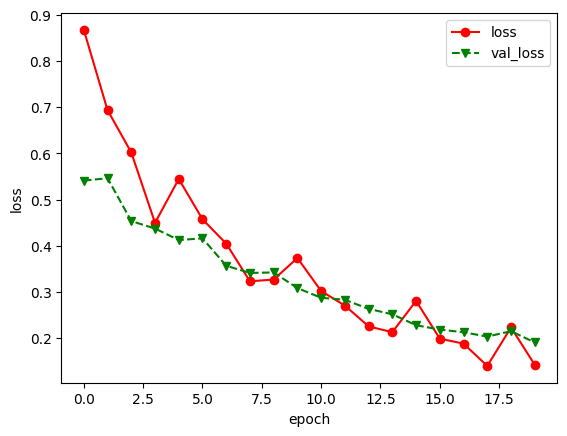

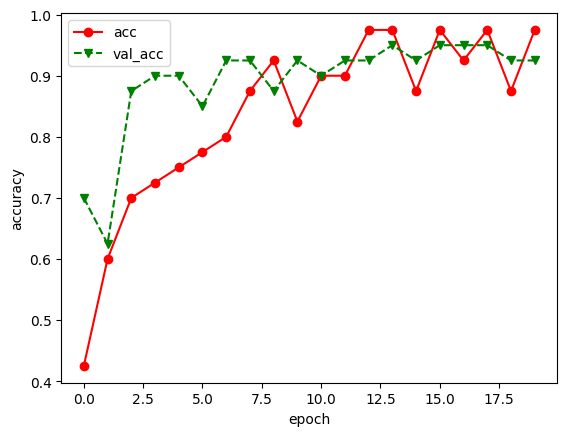

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

# GoogleDriveをマウント
from google.colab import drive
drive.mount("/content/drive")

# 画像サイズとディレクトリの設定
img_width, img_height = 150, 150
train_data_dir = 'drive/MyDrive/data/train'
test_data_dir = 'drive/MyDrive/data/test'

# エポック数の設定
epoch = 20

# 分類クラス名の設定
classes = ['horse','zebra']
nb_classes = len(classes)

# VGG16モデルのロード
vgg_model = VGG16(
        include_top = False,
        weights = 'imagenet',
        input_shape = (img_height, img_width, 3))

# VGG16モデルの下に全結合層を追加
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# VGG16モデルの上位15層のパラメータを凍結
for layer in vgg_model.layers[:15]:
    layer.trainable = False

model.summary()

# 損失関数は交差エントロピー、最適化手法はAdam
model.compile(
        loss = 'categorical_crossentropy',
        optimizer = SGD(0.001, 0.1),
        metrics = ['accuracy'])

# 学習データのデータ拡張を設定
train_datagen = ImageDataGenerator(
        rescale = 1.0 / 255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)

# 評価データのデータ拡張を設定
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

# 学習データのジェネレータを生成
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_height, img_width),
        classes = classes,
        batch_size = 32,
        class_mode = 'categorical')

# 評価データのジェネレータを生成
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (img_height, img_width),
        classes = classes,
        batch_size = 32,
        class_mode = 'categorical')

# コールバック関数（モデルの保存）の設定
mc_cb = ModelCheckpoint(
        filepath = 'drive/MyDrive/finetuning.h5',
        monitor = 'val_loss',
        verbose = 0,
        save_best_only = True)

# ジェネレータを用いたモデルの学習
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data = test_generator,
    callbacks = [mc_cb])

# 予測誤差のグラフ化
plt.plot(range(len(history.history['loss'])), history.history['loss'], marker='o', color = 'red', label='loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], marker='v', linestyle='--', color='green', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 予測精度のグラフ化
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], marker='o', color = 'red', label='acc')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], marker='v', linestyle='--', color = 'green', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()
